<a href="https://colab.research.google.com/github/geraldy-christanto/hoaxDetection/blob/master/GeraldyChristanto_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deskripsi Project #
<br>

Project akhir mata kuliah Probabilitas dan Proses stokastik ini dibuat oleh 
**Geraldy Christanto, Teknik Komputer 2017**.

Project ini menggunakan dua dataset, yaitu:


1.   LIAR dataset<br>
Dataset statement berita terdiri dari training set, validatian set, dan testing set. Statement ini diambil dari potongan-potongan berita dari berbagai sumber berita di Amerika mulai dari tahun 2007 - 2016.
2.   GloVe<br>
Global vectors for word representation [glove.6B.50d(URL Source: https://www.kaggle.com/watts2/glove6b50dtxt)] untuk mengklasifikasikan kata-kata yang ada dalam statement tersebut.


Dataset tersebut akan diolah dengan proses stokastik untuk didapatkan data berita yang palsu dan asli dengan menggunakan acuan dari testing set dan validation set. Hasil dari program ini yaitu dapat mendeteksi sebuah statement dengan menghasilkan probabilitas tingkat akurasi apakah statement itu dinyatakan BENAR atau PALSU dengan metode-metode stokastik dan Natural Language Processing menggunakan library SciKit.

#PERSIAPAN DATA#

**Import Library**

In [4]:
import pandas as pd
import csv
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk.corpus 
nltk.download('treebank')
import seaborn as sb
import matplotlib.pyplot as plt
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
from gensim.models.word2vec import Word2Vec

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


**Import data dari Github**

In [0]:
test_data = 'https://raw.githubusercontent.com/geraldy-christanto/hoaxDetection/master/test.csv'
train_data = 'https://raw.githubusercontent.com/geraldy-christanto/hoaxDetection/master/train.csv'
valid_data = 'https://raw.githubusercontent.com/geraldy-christanto/hoaxDetection/master/valid.csv'

train_news = pd.read_csv(train_data)
test_news = pd.read_csv(test_data)
valid_news = pd.read_csv(valid_data)

**Observasi Data**

In [0]:
#Fungsi untuk observasi dari dataset training, testing, dan validation
def data_obs():
    print("Ukuran dataset training:")
    print(train_news.shape)
    print(train_news.head(10))

    print("\nUkuran dataset testing:")
    print(test_news.shape)
    print(test_news.head(10))

    print("\nUkuran dataset validation:")
    print(valid_news.shape)
    print(valid_news.head(10))

In [7]:
data_obs()

Ukuran dataset training:
(10240, 2)
                                           Statement  Label
0  Says the Annies List political group supports ...  False
1  When did the decline of coal start? It started...   True
2  Hillary Clinton agrees with John McCain "by vo...   True
3  Health care reform legislation is likely to ma...  False
4  The economic turnaround started at the end of ...   True
5  The Chicago Bears have had more starting quart...   True
6  Jim Dunnam has not lived in the district he re...  False
7  I'm the only person on this stage who has work...   True
8  However, it took $19.5 million in Oregon Lotte...   True
9  Says GOP primary opponents Glenn Grothman and ...   True

Ukuran dataset testing:
(2551, 2)
                                           Statement  Label
0  Building a wall on the U.S.-Mexico border will...   True
1  Wisconsin is on pace to double the number of l...  False
2  Says John McCain has done nothing to help the ...  False
3  Suzanne Bonamici supports 

**Distribusi data dari masing-masing dataset**

In [0]:
def distribusi_data(dataFile):
    return sb.countplot(x='Label', data=dataFile, palette='hls')

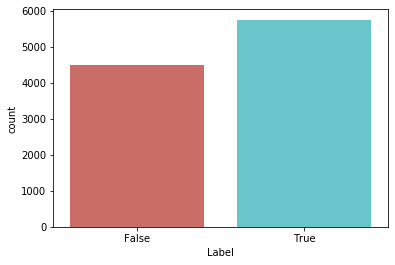

In [99]:
distribusi_data(train_news)

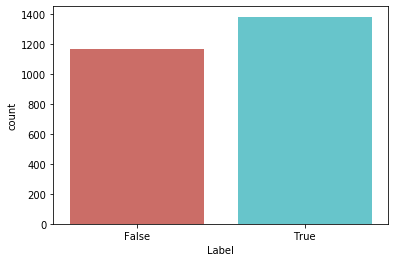

In [100]:
distribusi_data(test_news)

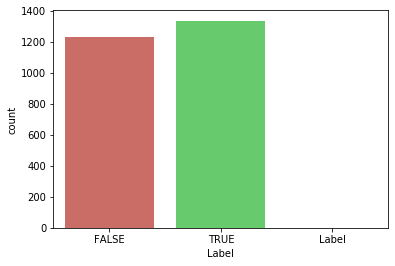

In [101]:
distribusi_data(valid_news)

Dari ketiga dataset tersebut terdapat dua jenis label dari setiap statement, yaitu **TRUE** dan **FALSE**. Hasil distribusi data dapat dilihat dalam plot grafik batang di atas. Statement berita yang memiliki label **TRUE** lebih banyak dari yang **FALSE**, karena untuk melakukan prediksi juga perlu mendapatkan data training yang memiliki nilai **TRUE** sebagai acuan untuk menghitung probabilitas apakah statement dari sebuah berita yang akan di input dalam program bernilai **TRUE** atau dengan kata lain, berita tersebut benar.

**Mengecek Kualitas Data**

Dari distribusi data yang telah dibuat, perlu dilakukan pengecekan kualitas data dari masing-masing dataset.

In [0]:
def data_quality():
    
    print("Training news info")
    train_news.isnull().sum()
    train_news.info()
        
    print("\nTesting news info")
    test_news.isnull().sum()
    test_news.info()

    print("\nValid news info")
    valid_news.isnull().sum()
    valid_news.info()

In [103]:
data_quality()

Training news info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
Statement    10240 non-null object
Label        10240 non-null bool
dtypes: bool(1), object(1)
memory usage: 90.1+ KB

Testing news info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 2 columns):
Statement    2551 non-null object
Label        2551 non-null bool
dtypes: bool(1), object(1)
memory usage: 22.5+ KB

Valid news info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2570 entries, 0 to 2569
Data columns (total 2 columns):
Statement    2570 non-null object
Label        2569 non-null object
dtypes: object(2)
memory usage: 40.3+ KB


Pengecekan kualitas data di atas menggunakan libray Pandas.Dataframe.
Pengecekan ini bertujuan untuk melihat informasi dari masing-masing dataset, yang berisikan jumlah kolom, data type masing-masing kolom beserta jumlah datanya, dan memory yang digunakan untuk memproses pengambilan informasi data tersebut.

#PENGOLAHAN DATA#

**Stemming Data**

Stemming merupakan proses normalisasi kata atau teks yang sering digunakan dalam Natural Language Processing untuk menyiapkan teks untuk dapat diproses lebih lanjut. Untuk menerapkan algoritma Stemming ini saya menggunakan llibrary **nltk** atau **Natural Language Tool Kit**.

In [0]:
#Fungsi Stemming
def stem_tokens(tokens, stemmer):
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
    return stemmed

#Proses data dengan fungsi stemming
def process_data(data,exclude_stopword=True,stem=True):
    tokens = [w.lower() for w in data]
    tokens_stemmed = tokens
    tokens_stemmed = stem_tokens(tokens, eng_stemmer)
    tokens_stemmed = [w for w in tokens_stemmed if w not in stopwords ]
    return tokens_stemmed

#Unigram
def create_unigram(words):
    assert type(words) == list
    return words

#Bigram
def create_bigrams(words):
    assert type(words) == list
    skip = 0
    join_str = " "
    Len = len(words)
    if Len > 1:
        lst = []
        for i in range(Len-1):
            for k in range(1,skip+2):
                if i+k < Len:
                    lst.append(join_str.join([words[i],words[i+k]]))
    else:
        lst = create_unigram(words)
    return lst

Untuk melakukan proses data text, saya menggunakan dua jenis N-gram. Pertama, menggunakan Unigram (1-gram) dan Bigram(2-gram). N-gram ini biasa digunakan untuk text mining dan Natural Language Processing. N-gram merupakan salah satu pemodelan probabilistik teks atau *speech* untuk memprediksi kata berikutnya dalam bentuk (n - 1) seperti Markov chain. Fungsi dari n-gram yaitu untuk menyederhanakan teks melalui sebuah model yang dapat menyimpan lebih banyak konteks dari sebuah kalimat, dan memungkinkan untuk meningkatkan efisiensi algoritma karena memiliki skalabilitas yang tinggi.

In [0]:
porter = PorterStemmer()

In [0]:
def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

Porter stemmer ini salah satu algoritma stemming yang sering digunakan untuk melakukan reduksi kata-kata dalam sebuah kalimat untuk menemukan 'akar' kata atau yang disebut lemma dengan melepas suffix atau prefixnya.

#KLASIFIKASI & SELEKSI

Proses klasifikasi ini, saya menggunakan library Sci-kit python, yang merupakan library untuk pemodelan prediksi. Setelah dibuat *tokenization* atau menguraikan teks menjadi kata, sehingga kata-kata tersebut dapat di encode menjadi bernilai integer atau floating point untuk digunakan sebagai input dalam algoritma machine learning, dalam hal ini menggunakan **sci-kit** yang disebut dengan extraction atau **vectorization**.

**1. CountVectorizer**

Fungsi ini digunakan untuk mengonversi teks menjadi vector dalam jumlah kata yang dimiliki pada statement dari training dataset.

In [0]:
countV = CountVectorizer()
train_count = countV.fit_transform(train_news['Statement'].values)

In [18]:
print(countV)
print(train_count)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
  (0, 9676)	1
  (0, 10988)	1
  (0, 1044)	1
  (0, 6639)	1
  (0, 8376)	1
  (0, 5115)	1
  (0, 10709)	1
  (0, 11036)	1
  (0, 11296)	1
  (0, 615)	1
  (0, 7728)	1
  (0, 3278)	1
  (1, 10988)	1
  (1, 11934)	2
  (1, 3434)	1
  (1, 3185)	1
  (1, 7672)	1
  (1, 2475)	1
  (1, 10425)	1
  (1, 6052)	1
  (1, 10426)	2
  (1, 7418)	1
  (1, 4860)	1
  (1, 11138)	1
  (1, 7674)	1
  :	:
  (10239, 10988)	1
  (10239, 7672)	2
  (10239, 11110)	2
  (10239, 5267)	1
  (10239, 7828)	1
  (10239, 7824)	1
  (10239, 1159)	1
  (10239, 12151)	2
  (10239, 6327)	1
  (10239, 6603)	1
  (10239, 11013)	1
  (10239, 11004)	1


In [0]:
def get_countVectorizer_stats():
    
    #Ukuran vocabulary dari training dataset
    train_count.shape

    #mengecek vocabulary menggunakan fungsi CountVectorizer 
    print(countV.vocabulary_)

    #Memperoleh pemetaan dalam bentuk array
    print(countV.get_feature_names()[:25])

**2. TfidfVectorizer**

Dalam tfidfVectorizer ini teks akan dikonversi menjadi vektor frekuensi kata. Parameter yang digunakan yaitu stop_words yaitu english karena dataset berita yang digunakan berbahasa Inggris, kemudian ngram_range dapat menggunakan jenis ngram tingkat 4.

In [0]:
tfidfV = TfidfTransformer()
train_tfidf = tfidfV.fit_transform(train_count)

def get_tfidf_stats():
    train_tfidf.shape
   
    print(train_tfidf.A[:10])

In [0]:
tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,4),use_idf=True,smooth_idf=True)

**Part-of-Speech Tagging** <br>
Pada tahap ini kata-kata yang telah di vectorizer akan dikategorikan berdasarkan kelas kata, seperti kata benda, kata kerja, kata sifat, dan lain-lain. Library yang digunakan yaitu nltk.corpus

In [22]:
#POS Tagging
tagged_sentences = nltk.corpus.treebank.tagged_sents()

cutoff = int(.75 * len(tagged_sentences))
training_sentences = train_news['Statement']
 
print(training_sentences)

0        Says the Annies List political group supports ...
1        When did the decline of coal start? It started...
2        Hillary Clinton agrees with John McCain "by vo...
3        Health care reform legislation is likely to ma...
4        The economic turnaround started at the end of ...
                               ...                        
10235    There are a larger number of shark attacks in ...
10236    Democrats have now become the party of the [At...
10237    Says an alternative to Social Security that op...
10238    On lifting the U.S. Cuban embargo and allowing...
10239    The Department of Veterans Affairs has a manua...
Name: Statement, Length: 10240, dtype: object


In [23]:
print(tagged_sentences)

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], ...]


Dapat kita lihat dalam potongan tagged_sentences di atas setiap kata dipisah dan memiliki kategori masing-masing. Arti dari setiap kategori tersebut dapat dilihat pada link berikut [link text](https://pythonprogramming.net/part-of-speech-tagging-nltk-tutorial/).

In [0]:
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }

In [0]:
def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Jika ingin mencoba silakan download terlebih dahulu file [Glove](https://drive.google.com/open?id=1JDunhUif5G3pcYo57h9-kfrbc0xGrksh) dari Google drive saya dan simpan ke dalam google drive anda. Simpan di halaman depan atau jika ingin dimasukkan ke dalam sebuah folder silakan atur directory pada fungsi open dibawah.

**Word2Vec**

Dengan file GloVe.6B.50d, dapat dihasilkan *word embedding* dengan merekonstruksi konteks kata-kata yang terdapat dalam GloVe tersebut. Word2vec mengambil kata dalam file GloVe sebagai input corpus dan menghasilkan sebuah vektor.

In [0]:
with open("/content/drive/My Drive/glove.6B.50d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

In [0]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [0]:
doc_new = ['obama is running for president in 2016']

**3. Naive Bayes**

Metode probabilitas dan proses stokastik pertama yang saya gunakan yaitu **naive bayes**. Naive bayes ini sebuah metode untuk melakukan klasifikasi menggunakan metode probabilitas dengan memprediksi peluang untuk masa yang akan datang (t) berdasarkan pengalaman di masa sebelumnya(t-1). Proses pada aplikasi ini yaitu pertama dengan menghitung jumlah label dari setiap statement pada train_news. Kemudian dari hasil pipeline dengan metode MultinomialNaiveBayes [MultinomialNB()]. Setelah itu, setiap jumlah kasus dari setiap label dari testing news akan di predict ketika labelnya itu sesuai dengan training news yang ada dengan membandingkan hasil per labelnya.

In [30]:
nb_pipeline = Pipeline([
        ('NBCV',countV),
        ('nb_clf',MultinomialNB())])

nb_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_nb = nb_pipeline.predict(test_news['Statement'])
np.mean(predicted_nb == test_news['Label'])

0.6072128577028616

**4. Logistic Regression**



In [31]:
logR_pipeline = Pipeline([
        ('LogRCV',countV),
        ('LogR_clf',LogisticRegression(solver='lbfgs', max_iter=1000))
        ])

logR_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_LogR = logR_pipeline.predict(test_news['Statement'])
np.mean(predicted_LogR == test_news['Label'])


0.5985887887103096

**5. Linear SVM**

In [32]:
svm_pipeline = Pipeline([
        ('svmCV',countV),
        ('svm_clf',svm.LinearSVC(max_iter=5000))
        ])

svm_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_svm = svm_pipeline.predict(test_news['Statement'])
np.mean(predicted_svm == test_news['Label'])


0.5723245785966288

**6. SVM Stochastic Gradient Descent on hinge loss**

In [33]:
sgd_pipeline = Pipeline([
        ('svm2CV',countV),
        ('svm2_clf',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))
        ])

sgd_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_sgd = sgd_pipeline.predict(test_news['Statement'])
np.mean(predicted_sgd == test_news['Label'])


0.6166209329674638

**7. Random Forest**

In [34]:
random_forest = Pipeline([
        ('rfCV',countV),
        ('rf_clf',RandomForestClassifier(n_estimators=200,n_jobs=3))
        ])
    
random_forest.fit(train_news['Statement'],train_news['Label'])
predicted_rf = random_forest.predict(test_news['Statement'])
np.mean(predicted_rf == test_news['Label'])

0.6256370050960408

Fungsi untuk membuat confusion matrix berdasarkan classifiernya.
Confusion matrix merupakan ringkasan hasil prediksi dari klasifikasi yang telah dibuat. Jumlah prediksi benar atau salah akan didapatkan dengan menghitung nilai berdasarkan setiap label atau kelasnya. 

In [0]:
def build_confusion_matrix(classifier):
    
    k_fold = KFold(n_splits=5)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(train_news):
        train_text = train_news.iloc[train_ind]['Statement'] 
        train_y = train_news.iloc[train_ind]['Label']
    
        test_text = train_news.iloc[test_ind]['Statement']
        test_y = train_news.iloc[test_ind]['Label']
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        scores.append(score)
    
    return (print('Total statements classified:', len(train_news)),print('Score:', sum(scores)/len(scores)),print('score length', len(scores)),print('Confusion matrix:'),print(confusion))

In [36]:
print(' Naive Bayes ')
build_confusion_matrix(nb_pipeline)
print('\n Logistic Regression ')
build_confusion_matrix(logR_pipeline)
print('\n SVM ')
build_confusion_matrix(svm_pipeline)
print('\n SGD ')
build_confusion_matrix(sgd_pipeline)
print('\n Random Forest ')
build_confusion_matrix(random_forest)


 Naive Bayes 
Total statements classified: 10240
Score: 0.66961153965076
score length 5
Confusion matrix:
[[2118 2370]
 [1664 4088]]

 Logistic Regression 
Total statements classified: 10240
Score: 0.6467945943441228
score length 5
Confusion matrix:
[[2252 2236]
 [1934 3818]]

 SVM 
Total statements classified: 10240
Score: 0.6104687487924283
score length 5
Confusion matrix:
[[2260 2228]
 [2246 3506]]

 SGD 
Total statements classified: 10240
Score: 0.6617719287551973
score length 5
Confusion matrix:
[[2195 2293]
 [1773 3979]]

 Random Forest 
Total statements classified: 10240
Score: 0.701629296252633
score length 5
Confusion matrix:
[[1802 2686]
 [1192 4560]]


(None, None, None, None, None)

**Klasifikasi N-gram per metode**

In [37]:
#naive-bayes
nb_pipeline_ngram = Pipeline([
        ('nb_tfidf',tfidf_ngram),
        ('nb_clf',MultinomialNB())])

nb_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_nb_ngram = nb_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_nb_ngram == test_news['Label'])


0.5938847510780086

In [38]:
#logistic regression
logR_pipeline_ngram = Pipeline([
        ('LogR_tfidf',tfidf_ngram),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1, solver='lbfgs'))
        ])

logR_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_LogR_ngram = logR_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_LogR_ngram == test_news['Label'])


0.6193649549196394

In [39]:
#linear SVM
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf',tfidf_ngram),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_svm_ngram = svm_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_svm_ngram == test_news['Label'])


0.6170129361034888

In [40]:
#SGD 
sgd_pipeline_ngram = Pipeline([
         ('sgd_tfidf',tfidf_ngram),
         ('sgd_clf',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))#, n_iter=5))
         ])

sgd_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_sgd_ngram = sgd_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_sgd_ngram == test_news['Label'])


0.5417483339866719

In [41]:
#Random forest
random_forest_ngram = Pipeline([
        ('rf_tfidf',tfidf_ngram),
        ('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=3))
        ])
    
random_forest_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_rf_ngram = random_forest_ngram.predict(test_news['Statement'])
np.mean(predicted_rf_ngram == test_news['Label'])


0.604860838886711

**K-fold cross validation untuk setiap classifier**

In [42]:
print('K-Fold Naive Bayes ')
build_confusion_matrix(nb_pipeline_ngram)
print('\n K-fold Logistic Regression ')
build_confusion_matrix(logR_pipeline_ngram)
print('\n K-fold SVM ')
build_confusion_matrix(svm_pipeline_ngram)
print('\n K-fold SGD ')
build_confusion_matrix(sgd_pipeline_ngram)
print('\n K-fold Random Forest ')
build_confusion_matrix(random_forest_ngram)

K-Fold Naive Bayes 
Total statements classified: 10240
Score: 0.7224053159841455
score length 5
Confusion matrix:
[[ 758 3730]
 [ 390 5362]]

 K-fold Logistic Regression 
Total statements classified: 10240
Score: 0.7044355553757985
score length 5
Confusion matrix:
[[1580 2908]
 [1043 4709]]

 K-fold SVM 
Total statements classified: 10240
Score: 0.6790920142902143
score length 5
Confusion matrix:
[[2016 2472]
 [1524 4228]]

 K-fold SGD 
Total statements classified: 10240
Score: 0.7189849719606326
score length 5
Confusion matrix:
[[   5 4483]
 [   7 5745]]

 K-fold Random Forest 
Total statements classified: 10240
Score: 0.6555154363630729
score length 5
Confusion matrix:
[[1996 2492]
 [1732 4020]]


(None, None, None, None, None)

In [43]:
print(classification_report(test_news['Label'], predicted_nb_ngram))
print(classification_report(test_news['Label'], predicted_LogR_ngram))
print(classification_report(test_news['Label'], predicted_svm_ngram))
print(classification_report(test_news['Label'], predicted_sgd_ngram))
print(classification_report(test_news['Label'], predicted_rf_ngram))

test_news['Label'].shape

              precision    recall  f1-score   support

       False       0.72      0.19      0.30      1169
        True       0.58      0.94      0.71      1382

    accuracy                           0.59      2551
   macro avg       0.65      0.56      0.51      2551
weighted avg       0.64      0.59      0.52      2551

              precision    recall  f1-score   support

       False       0.64      0.39      0.49      1169
        True       0.61      0.81      0.70      1382

    accuracy                           0.62      2551
   macro avg       0.62      0.60      0.59      2551
weighted avg       0.62      0.62      0.60      2551

              precision    recall  f1-score   support

       False       0.61      0.47      0.53      1169
        True       0.62      0.74      0.68      1382

    accuracy                           0.62      2551
   macro avg       0.61      0.61      0.60      2551
weighted avg       0.62      0.62      0.61      2551

              preci

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(2551,)

In [0]:
#parameter untuk random forest classifier
parameters = {'rf_tfidf__ngram_range': [(1, 1), (1, 2),(1,3)],
               'rf_tfidf__use_idf': (True, False),
               'rf_clf__max_depth': (1,2,3,4,5,6,7,8,9,10)
}

gs_clf = GridSearchCV(random_forest_ngram, parameters, cv = 5,n_jobs=-1)
gs_clf = gs_clf.fit(train_news['Statement'][:5000],train_news['Label'][:5000])

In [0]:
#parameter untuk logistic regression
parameters = {'LogR_tfidf__ngram_range': [(1, 1), (1, 2),(1,3)],#(1,4),(1,5)],
               'LogR_tfidf__use_idf': (True, False),
               'LogR_tfidf__smooth_idf': (True, False)
}

gs_clf = GridSearchCV(logR_pipeline_ngram, parameters, n_jobs=-1, cv =5)
gs_clf = gs_clf.fit(train_news['Statement'][:5000],train_news['Label'][:5000])

In [0]:
#parameter untuk Linear SVM 
parameters = {'svm_tfidf__ngram_range': [(1, 1), (1, 2),(1,3)],
               'svm_tfidf__use_idf': (True, False),
               'svm_tfidf__smooth_idf': (True, False),
               'svm_clf__penalty': ('l1','l2'),
}

gs_clf = GridSearchCV(svm_pipeline_ngram, parameters, n_jobs=-1, error_score = 0.0, cv =5)
gs_clf = gs_clf.fit(train_news['Statement'][:10000],train_news['Label'][:10000])

In [52]:
#Menjalankan random forest dan logistic regression dengan metode GridSearch
random_forest_final = Pipeline([
        ('rf_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,3),use_idf=True,smooth_idf=True)),
        ('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=3,max_depth=10))
        ])
    
random_forest_final.fit(train_news['Statement'],train_news['Label'])
predicted_rf_final = random_forest_final.predict(test_news['Statement'])
np.mean(predicted_rf_final == test_news['Label'])
print(metrics.classification_report(test_news['Label'], predicted_rf_final))

              precision    recall  f1-score   support

       False       0.50      0.00      0.00      1169
        True       0.54      1.00      0.70      1382

    accuracy                           0.54      2551
   macro avg       0.52      0.50      0.35      2551
weighted avg       0.52      0.54      0.38      2551



In [53]:
logR_pipeline_final = Pipeline([
        ('LogR_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,5),use_idf=True,smooth_idf=False)),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1, solver="lbfgs"))
        ])

logR_pipeline_final.fit(train_news['Statement'],train_news['Label'])
predicted_LogR_final = logR_pipeline_final.predict(test_news['Statement'])
np.mean(predicted_LogR_final == test_news['Label'])
print(metrics.classification_report(test_news['Label'], predicted_LogR_final))

              precision    recall  f1-score   support

       False       0.64      0.38      0.48      1169
        True       0.61      0.82      0.70      1382

    accuracy                           0.62      2551
   macro avg       0.62      0.60      0.59      2551
weighted avg       0.62      0.62      0.60      2551



In [0]:
#Menyimpan model final ke dalam disk
model_file = 'final_model.sav'
pickle.dump(logR_pipeline_ngram,open(model_file,'wb'))

#VISUALISASI#

In [0]:
def plot_learning_curve(pipeline,title):
    
    X = train_news["Statement"]
    y = train_news["Label"]
    
    pl = pipeline
    pl.fit(X,y)
    
    train_sizes, train_scores, test_scores = learning_curve(pl, X, y, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
       
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
     
    plt.figure()
    plt.title(title)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.ylim(-.1,1.1)
    plt.show()

**Plot learning curve untuk setiap classifier**

No handles with labels found to put in legend.


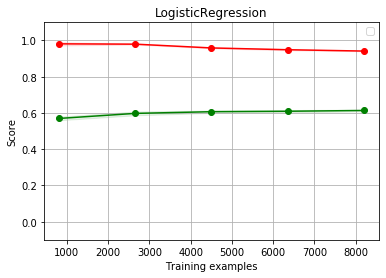

In [78]:
plot_learning_curve(logR_pipeline_ngram,"LogisticRegression")

No handles with labels found to put in legend.


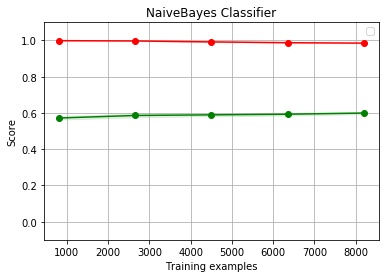

In [79]:
plot_learning_curve(nb_pipeline_ngram,"NaiveBayes Classifier")

No handles with labels found to put in legend.


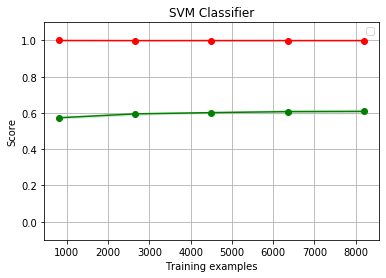

In [80]:
plot_learning_curve(svm_pipeline_ngram,"SVM Classifier")

Dari learning curve di atas, untuk LogRes, dapat dilihat bahwa score untuk cross-validation stagnan. Hasil tersebut menunjukkan tingkat akurasi yang perlu ditingkatkan lagi dalam sisi algoritma pipeline untuk setiap classifier. Model terbaik dari plot ini akan digunakan untuk melakukan prediksi.

**2. Kurva Precision-Recall** <bR>
Kurva untuk menentukan akurasi yang didapatkan dari confusion matrix dengan mendapatkan case yang terdapat dalam class positive(True).
Data precision merupakan pengukuran seberapa berkualitasnya data training yang telah di klasifikasikan, sedangkan Recall menentukan seberapa lengkap hasil yang relevan antara training dataset dengan testing data.

In [0]:
#plotting Precision-Recall curve
def plot_PR_curve(classifier):
    
    precision, recall, thresholds = precision_recall_curve(test_news['Label'], classifier)
    average_precision = average_precision_score(test_news['Label'], classifier)
    
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Random Forest Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

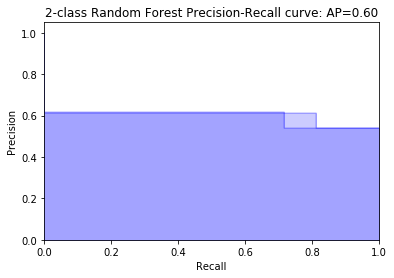

In [105]:
plot_PR_curve(predicted_LogR_ngram)
plot_PR_curve(predicted_rf_ngram)

Dari kurva di atas didapatkan rata-rata nilai precisionnya yaitu 0.60, yang berarti akurasi dari perhitungan probabilitas untuk menentukan apakah statement itu bernilai TRUE atau FALSE yaitu 0.60 dari 1.00. Sehingga program ini perlu terus ditingkatkan lagi, baik dari sisi kompleksitas, jumlah dataset yang perlu ditingkatkan, maupun algoritma yang digunakan.

In [0]:
def show_most_informative_features(model, vect, clf, text=None, n=50):
    vectorizer = model.named_steps[vect]
    classifier = model.named_steps[clf]

    if not hasattr(classifier, 'coef_'):
        raise TypeError(
            "Cannot compute most informative features on {}.".format(
                classifier.__class__.__name__
            )
        )
            
    if text is not None:
        tvec = model.transform([text]).toarray()
    else:
        tvec = classifier.coef_

    coefs = sorted(
        zip(tvec[0], vectorizer.get_feature_names()),
        reverse=True
    )
    
    topn  = zip(coefs[:n], coefs[:-(n+1):-1])

    output = []
    if text is not None:
        output.append("\"{}\"".format(text))
        output.append(
            "Classified as: {}".format(model.predict([text]))
        )
        output.append("")

    for (cp, fnp), (cn, fnn) in topn:
        output.append(
            "{:0.4f}{: >15}    {:0.4f}{: >15}".format(
                cp, fnp, cn, fnn
            )
        )
    print(output)

In [88]:
show_most_informative_features(logR_pipeline_ngram,vect='LogR_tfidf',clf='LogR_clf')
show_most_informative_features(nb_pipeline_ngram,vect='nb_tfidf',clf='nb_clf')
show_most_informative_features(svm_pipeline_ngram,vect='svm_tfidf',clf='svm_clf')
show_most_informative_features(sgd_pipeline_ngram,vect='sgd_tfidf',clf='sgd_clf')

['3.3274        percent    -2.0938      obamacare', '1.8485        million    -1.8249          obama', '1.7409        average    -1.6505           says', '1.6573            day    -1.5980      wisconsin', '1.6514        georgia    -1.4068            rep', '1.6174           debt    -1.3510     government', '1.6029      countries    -1.2283           care', '1.5744          times    -1.2013           plan', '1.4221        highest    -1.1898      president', '1.3850        country    -1.1784   scott walker', '1.3490           half    -1.1635         walker', '1.3286            000    -1.0761         obamas', '1.2220       american    -1.0428          scott', '1.2136            cut    -1.0123           away', '1.2060         months    -0.9792        clinton', '1.1675         states    -0.9715         barack', '1.1637      americans    -0.9658       medicare', '1.0659           rate    -0.9373       stimulus', '1.0616           year    -0.9210          white', '1.0163             60    -0.9

#PENDETEKSI FAKE NEWS#

In [108]:
import pickle

var = input("Masukkan statement berita yang ingin di verifikasi: ")
print("Statement yang dimasukkan: " + str(var))

#Fungsi untuk mendeteksi fake news
def detecting_fake_news(var):    
#Mengambil model terbaik dari final model
    load_model = pickle.load(open('final_model.sav', 'rb'))
    prediction = load_model.predict([var])
    prob = load_model.predict_proba([var])

    return (print("Statement yang dimasukkan bernilai ",prediction[0]),
        print("Probabilitas ",prob[0][1]))

if __name__ == '__main__':
    detecting_fake_news(var)

Masukkan statement berita yang ingin di verifikasi: Pope Francis has endorsed Hilarry Clinton for President
Statement yang dimasukkan: Pope Francis has endorsed Hilarry Clinton for President
Statement yang dimasukkan bernilai  False
Probabilitas  0.38713978436649016
